In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [35]:
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

ImportError: cannot import name 'mean_absolute_percentage_error'

In [3]:
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [5]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15, 5))
    plt.title("Moving Average\nWindow Size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_intervals:
        MAE = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (MAE + scale * deviation)
        upper_bond = rolling_mean + (MAE + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="best")
    plt.grid(True)
        

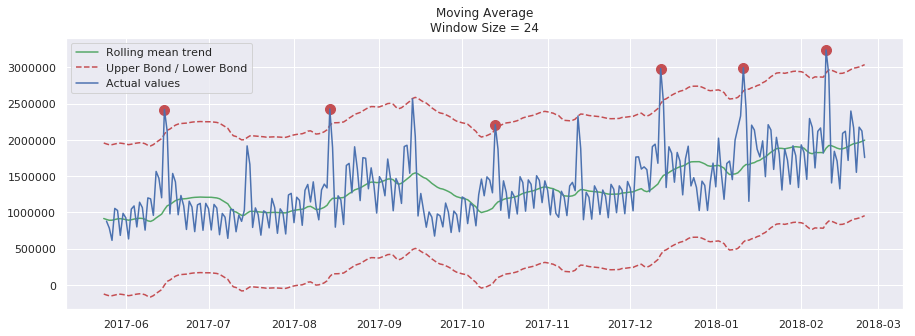

In [6]:
plotMovingAverage(currency, 24, plot_intervals=1, plot_anomalies=1)

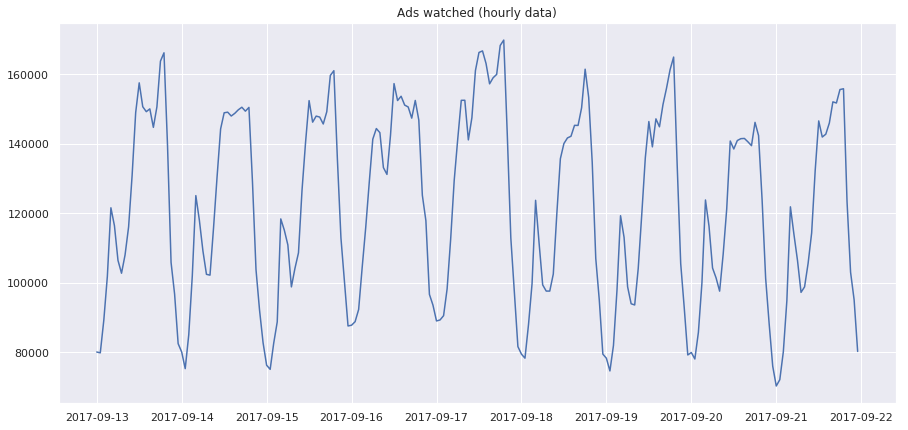

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

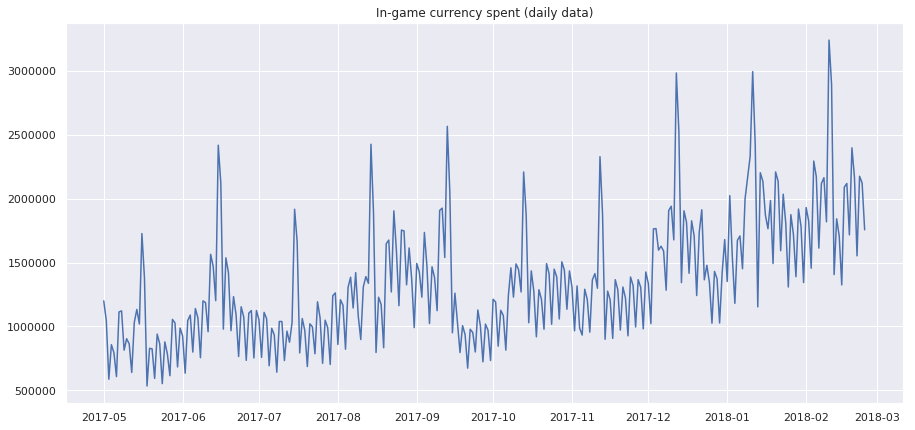

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

### 单指数平滑

In [9]:
def expotential_smoothing(series, alpha):
    result = [series[0]] # 因为第一个值不存在指数平滑值
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [10]:
def plotExpotentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(expotential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Expotential Smoothing")
        plt.grid(True)

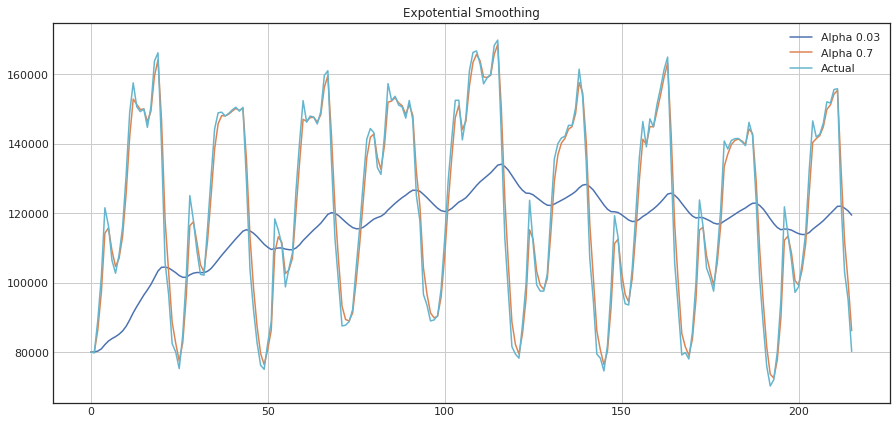

In [11]:
plotExpotentialSmoothing(ads.Ads, [0.03, 0.7])

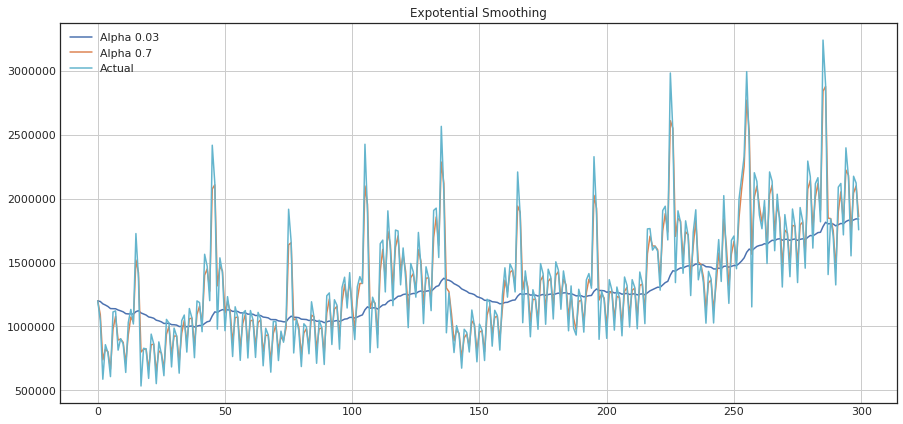

In [12]:
plotExpotentialSmoothing(currency.GEMS_GEMS_SPENT, [0.03, 0.7])

### 双指数平滑

单指数平滑只考虑了K条历史数据的**静态**影响，并没有考虑整体的趋势`也不能说完全没有包括趋势影响，主要的问题是由近及远的权重衰减并不是专注于趋势本身`，同时考虑历史和变化趋势，就是**双指数平滑**
通过**序列分解法**(series decomposition)，可以得到两个分量，一个是Level(也叫intercept 截距？我觉得应该叫高度差比较合适，本身就是最近几个点的比较)$\ell$，一个是Trend(也叫slope 斜率，这个确实可以理解为趋势)

$\ell_x = \alpha y_x + (1 - \alpha)(\ell_{x-1} + {\mathcal b}_{x-1})$ 实际上这里的高度差就是真实值和前一个预测值的加权平均

${\mathcal b}_x = \beta(\ell_x - \ell_{x-1}) + (1 - \beta){\mathcal b}_{x-1}$ 高度差的加权平均(高度差在等单位的情况下可以近似理解为斜率)

$\hat{y}_{x+1} = \ell_x + {\mathcal b}_x$ 高度差 + 斜率

In [13]:
def double_expotential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    
    # 初始化结果
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0] # 第一个点截距为自己，趋势就是它与前一个点的差
        if n >= len(series):
            value = result[-1] # value 就是真实值 y_x 这种，详情可以看下面level的计算
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta*(level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plotDoubleExpotentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_expotential_smoothing(series, alpha, beta), label="Alpha {}, Beta {}".format(alpha, beta))
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Expotential Smoothing")
        plt.grid(True)

ads.Ads 没有实际上**趋势**，所以正常情况下单指数平滑就够了

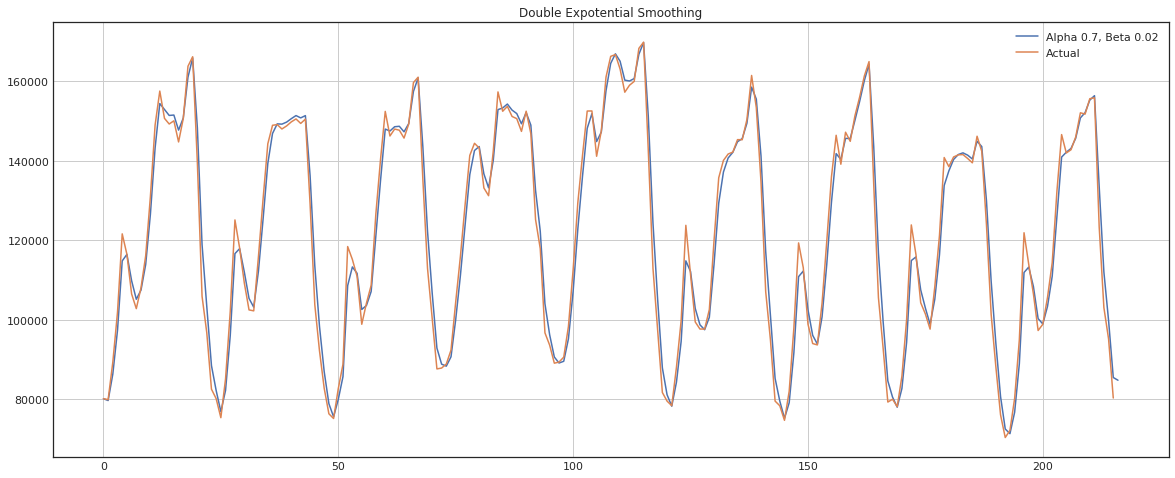

In [14]:
plotDoubleExpotentialSmoothing(ads.Ads, alphas=[0.7], betas=[0.02])

currency.GEM_GEM_SPENT 有趋势，所以应该是用双指数

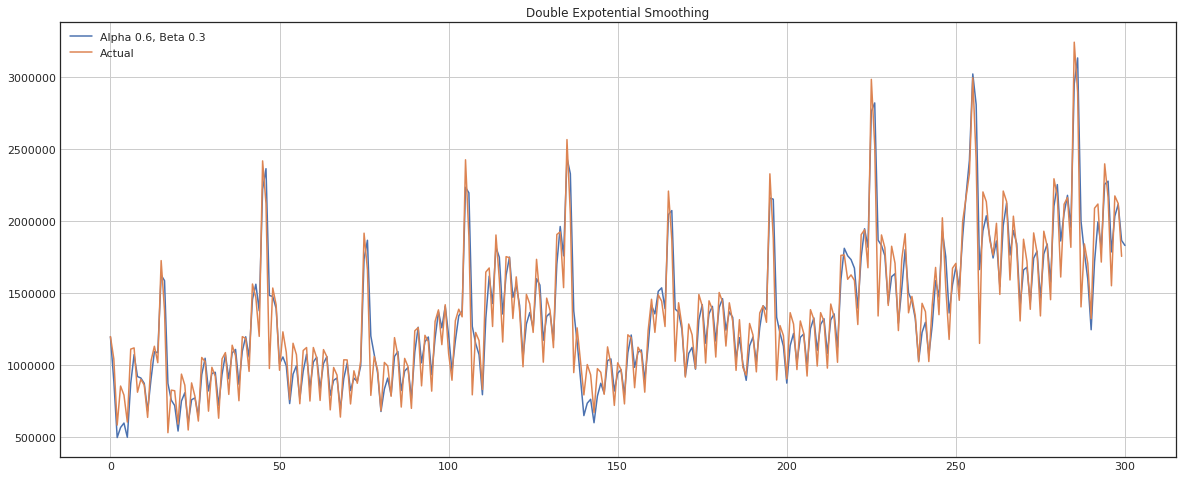

In [15]:
plotDoubleExpotentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.6], betas=[0.3])

### 三指数平滑

也叫Holt-Winters平滑，增加了一个因素——**季节**。
所谓**季节性分量**，就是解释**高度差**和**趋势**的重复变化，由季节长度(变化周期性)描述。
对于周期内的每个点，都是一个单独的组成，比如季节长度为7(周季节性),就有7个组成，周中的每一天都对应一个（周一对应周一的季节因素，周二对应周二的）。

$\ell_x = \alpha (y_x - s_{x-L}) + (1 - \alpha)(\ell_{x-1} + {\mathcal b}_{x-1})$

${\mathcal b}_x = \beta(\ell_x - \ell_{x-1}) + (1 - \beta){\mathcal b}_{x-1}$

$s_x = \gamma (y_x - \ell_x) + (1 - \gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + m{\mathcal b}_x + s_{x-L+1+(m-1)modL}$

- 在Holt-Winters模型中，设置置信区间使用Brutlag方法：

    $\hat{y}_{max_x} = \ell_{x-1} + {\mathcal b}_{x-1} + s_{x-T} + m \centerdot d_{t-T}$

    $\hat{y}_{min_x} = \ell_{x-1} + {\mathcal b}_{x-1} + s_{x-T} - m \centerdot d_{t-T}$

    $d_t = \gamma \vert y_t - \hat{y}_t \vert + (1 - \gamma)d_{t-T}$
    
    T为季节长度，d为误差

In [29]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
#         print(len(series))
    
    def init_trend(self):
        s = 0.0
        for i in range(self.slen):
            s += (self.series[i+self.slen] - self.series[i])/self.slen
        return s / self.slen
    
    def init_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
#         print(self.series, n_seasons)
        
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j: self.slen*(j+1)])/self.slen)
        
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    def triple_expotential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.init_seasonal_components()
        
        for i in range(len(self.series) + self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.init_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(
                    self.result[0] +
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                self.LowerBond.append(
                    self.result[0] -
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append(smooth + m * trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.PredictedDeviation[-1] * 1.01
                )
            else:
                # 我觉得这段代码是有问题的，待后续排查
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i]) +
                    (1 - self.gamma) * self.PredictedDeviation[-1]
                )
            
            self.UpperBond.append(
                self.result[-1] +
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.LowerBond.append(
                self.result[-1] -
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

### 关于交叉验证（K-fold Cross-Validation）—— 时间序列

时间序列的特殊性在于其特有的时序结构不能被破坏，所以一般的CV方法是无法使用的，这里采用一个技巧性方法——滚动交叉验证
- fold1: training[1] test[2]
- fold2: training[1 2] test[3]
- fold3: training[1 2 3] test[4]
- fold4: training[1 2 3 4] test[5]

In [18]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    
    errors = []
    values = series.values
    alpha, beta, gamma = params
    
    # 拆几个fold来做交叉验证
    tscv = TimeSeriesSplit(n_splits = 3)
    
    for train, test in tscv.split(values):
        model = HoltWinters(
            series = values[train],
            slen = slen,
            alpha = alpha,
            beta = beta,
            gamma = gamma,
            n_preds = len(test)
        )
        
        model.triple_expotential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

在Holt-Winters模型和其他指数平滑模型中，对于参数取值有限制，所以需要选择支持模型参数约束的最优化算法，这里我们使用**Truncated Newton conjugate gradient（截断牛顿共轭梯度法）**

In [65]:
data = ads.Ads[:-20] # 剩下的 20 是 test 集
slen = 24
# data = currency.GEMS_GEMS_SPENT[:-50]
# slen = 30
# 初始化Alpha，Beta，Gamma
x = [0, 0, 0]

# 最小化损失函数
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(
        data,
        mean_squared_log_error,
        slen
    ),
    method="TNC",
    bounds = (
        (0, 1),
        (0, 1),
        (0, 1)
    )
)
# 获得返回值
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen=slen,
                   alpha = alpha_final,
                   beta = beta_final,
                   gamma = gamma_final,
                   n_preds = 50,
                   scaling_factor=3
                   )
model.triple_expotential_smoothing()

0.11681811415263998 0.002674202051183794 0.059665015439133884


In [38]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values < model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low Confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0, len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.2, color="grey")
    
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles="dashed")
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=12)

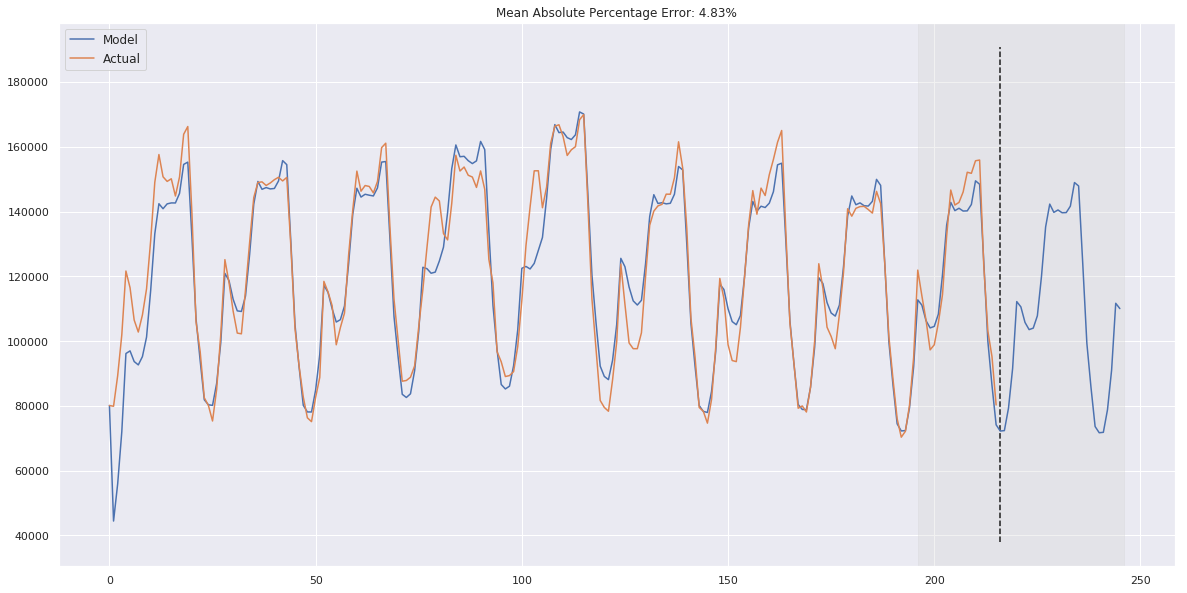

In [66]:
plotHoltWinters(ads.Ads)

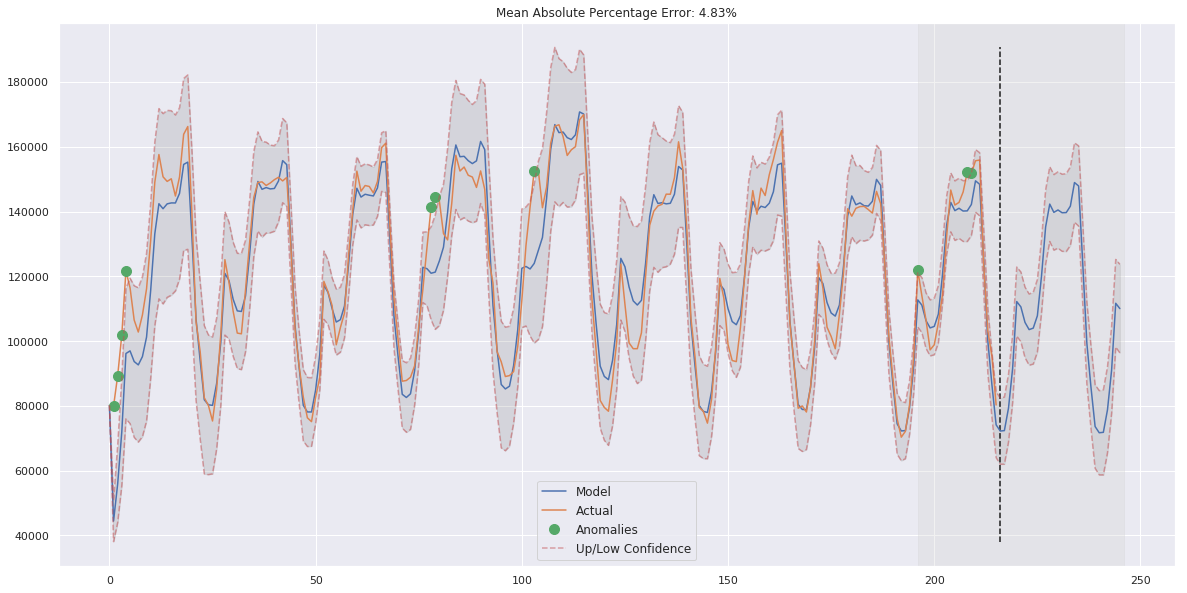

In [67]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

In [90]:
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_expotential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777


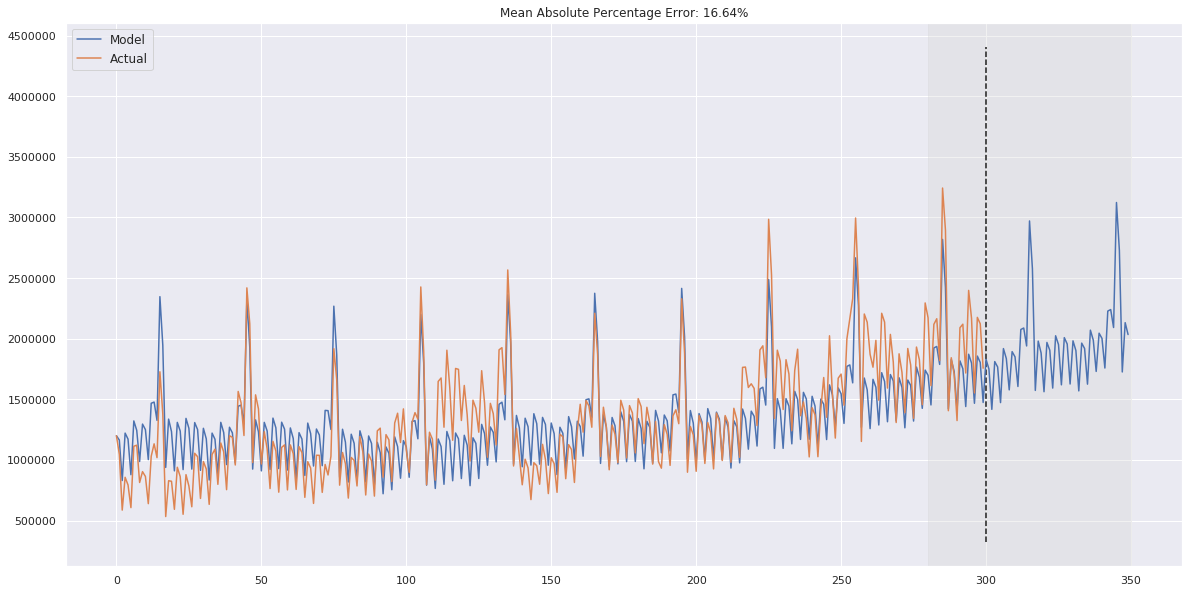

In [91]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

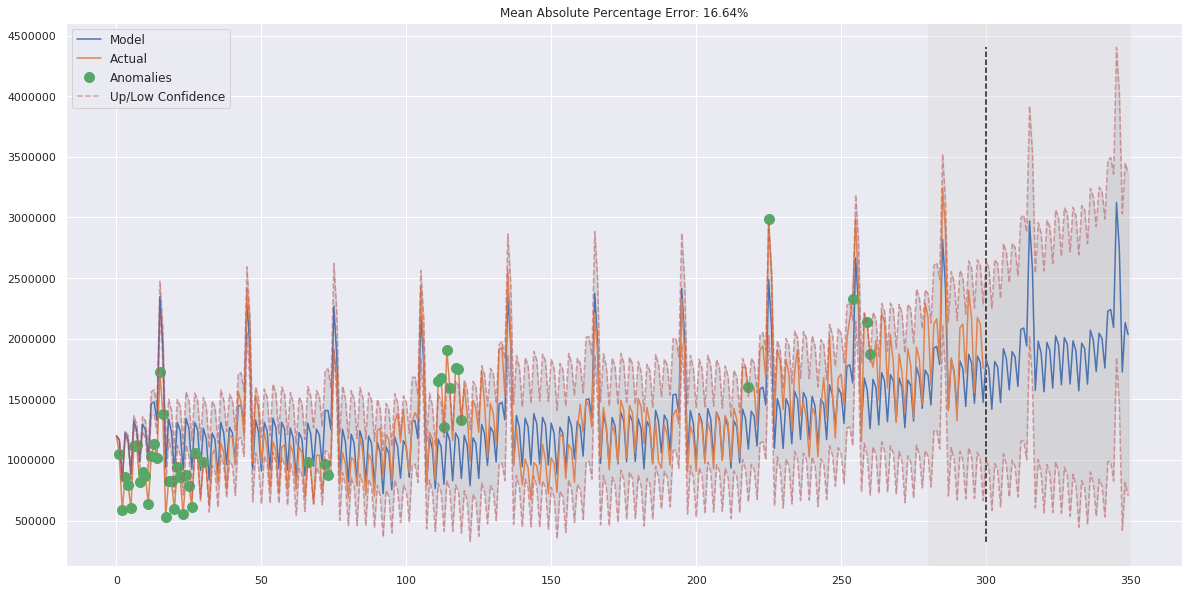

In [92]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)